# Analyze Energy Ratios with Wake Steering

In this notebook, we will compare energy ratios computed using data from baseline and wake steering control periods. The energy ratios for the two control cases will be compared to evaluate the impact of wake steering on the energy production of the test turbines.

In [1]:

from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from flasc.visualization import plot_binned_mean_and_ci

from flasc.energy_ratio import energy_ratio_suite

from models import load_smarteole_floris

import copy

In [2]:
# Suppress warnings
import warnings

warnings.filterwarnings('ignore')

# Step 0: Load processed data

Load the processed SCADA data with power curve filtering and northing calibration applied and inspect

In [3]:
def load_data():
    root_path = Path.cwd()
    f = root_path / "postprocessed" / "df_scada_data_60s_filtered_and_northing_calibrated.ftr"
    df_scada = pd.read_feather(f)

    # # Optionally: downsample to [x] minute averages to speed up things
    # cols_angular = [c for c in df_scada if (("wd_" in c) or ("yaw_" in c))]
    # df_scada = fto.df_downsample(
    #     df_scada,
    #     cols_angular=cols_angular,
    #     window_width=td(seconds=600),
    # )

    return df_scada

df_scada = load_data()

In [4]:
df_scada.describe()

,pow_000,pow_001,pow_002,pow_003,pow_004,pow_005,pow_006,ws_000,ws_001,ws_002,...,wd_004,wd_005,wd_006,wind_vane_005,target_yaw_offset_005,wd_smarteole,ws_smarteole,pow_ref_smarteole,ti,wd
count,107990.000000,104834.000000,91602.000000,100703.000000,104591.000000,100064.000000,105990.000000,107990.000000,104834.000000,91602.000000,...,104591.000000,100064.000000,105990.000000,100064.000000,100064.000000,131704.000000,131699.000000,130266.000000,1.346610e+05,115694.000000
mean,777.653931,722.490112,787.805054,650.537537,708.335510,711.493103,734.078857,7.992405,7.442919,7.758101,...,148.641602,152.192139,146.140839,0.822919,0.783870,147.975891,7.286751,639.086548,1.100000e-01,147.147975
std,639.254761,609.922241,636.098022,560.755066,612.281738,624.734497,617.581970,2.547888,2.501712,2.513086,...,99.421783,97.336273,97.354767,10.042883,3.210437,101.749596,3.104111,629.421387,8.326704e-17,100.092758
min,0.001000,0.003000,0.002000,0.009000,0.007000,0.032000,0.000000,1.483000,2.746000,1.483000,...,0.022003,0.009750,0.192000,-43.056999,-0.000000,0.005936,0.101000,-45.498859,1.100000e-01,0.035300
25%,235.364014,214.135498,246.605499,193.113007,205.125000,174.702759,219.265747,6.128000,5.578000,5.919000,...,50.771000,52.388748,49.512001,-5.913000,-0.000000,47.813652,5.121595,98.970131,1.100000e-01,47.626443
50%,571.507019,528.515503,592.422974,467.604004,501.115997,508.388489,540.299988,7.448000,7.027000,7.188000,...,129.255997,159.308258,135.268494,0.185000,-0.000000,138.522034,7.423318,422.463989,1.100000e-01,136.650682
75%,1238.221802,1120.502441,1242.167236,997.825989,1085.923462,1133.235962,1132.259033,9.587000,8.945000,9.252000,...,235.914993,234.888504,232.869751,6.917000,0.000000,235.295441,9.361652,1049.996338,1.100000e-01,233.836438
max,2064.696045,2065.387939,2051.489990,2062.987061,2063.420898,2078.750977,2076.895996,20.851999,21.240999,20.374001,...,359.997009,359.980743,359.989014,59.181999,20.000000,359.991791,20.422459,2147.802246,1.100000e-01,359.957791


In [5]:
df_scada.columns

Index(['time', 'pow_000', 'pow_001', 'pow_002', 'pow_003', 'pow_004',
       'pow_005', 'pow_006', 'ws_000', 'ws_001', 'ws_002', 'ws_003', 'ws_004',
       'ws_005', 'ws_006', 'wd_000', 'wd_001', 'wd_002', 'wd_003', 'wd_004',
       'wd_005', 'wd_006', 'is_operation_normal_000',
       'is_operation_normal_001', 'is_operation_normal_002',
       'is_operation_normal_003', 'is_operation_normal_004',
       'is_operation_normal_005', 'is_operation_normal_006', 'wind_vane_005',
       'target_yaw_offset_005', 'control_mode', 'wd_smarteole', 'ws_smarteole',
       'pow_ref_smarteole', 'ti', 'wd'],
      dtype='object')

# Step 1: Evaluate offsets

Compare the targeted offsets against what was achieved (as measured by the vane on the steering turbine SMV6 (index=5))

In [6]:
# Parameters
start_of_offset = 200 # deg
end_of_offset = 240 # deg

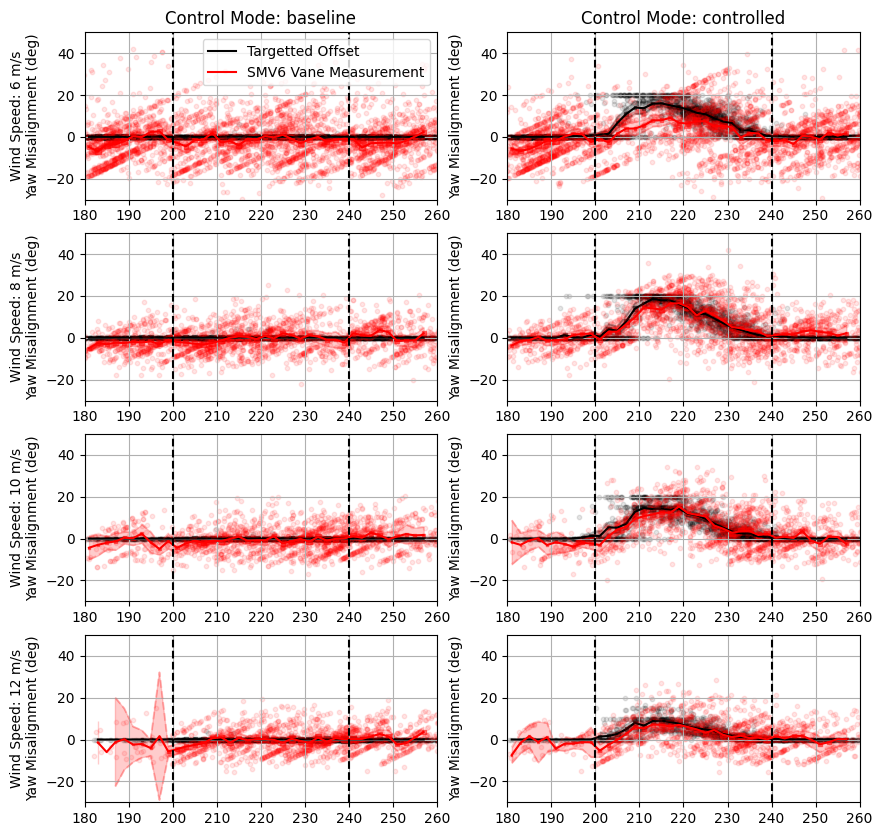

In [7]:
# Add a rounded ws column
df_scada = df_scada.assign(
    ws_round = df_scada.ws_005.round(),
    wd_to_plot = df_scada.wd_005
 )

# Limit to a few wind speeds for plotting
wind_speeds_to_plot = [6,8,10,12]
df_plot = df_scada[df_scada.ws_round.isin(wind_speeds_to_plot)]

# Melt together targeted and achieved 
df_plot = (df_plot
    [['wd_to_plot','ws_round','target_yaw_offset_005','wind_vane_005','control_mode']]
    # .melt(id_vars=['wd_round','ws_round','control_mode'],
    #       var_name='offset_type',
    #       value_name='offset_value')
    .sort_values(['wd_to_plot','ws_round'])
)

# Set up binning plots
x_edges = np.arange(start_of_offset - 20, end_of_offset + 20, 2)

fig, axarr = plt.subplots(len(wind_speeds_to_plot),2, figsize=(10,10))

for ws_idx, ws in enumerate(wind_speeds_to_plot):
    for c_idx, control_mode in enumerate(['baseline','controlled']):

        ax = axarr[ws_idx, c_idx]
        df_sub = df_plot[(df_plot.ws_round==ws) & (df_plot.control_mode==control_mode)]

        plot_binned_mean_and_ci(df_sub.wd_to_plot,
                                df_sub.target_yaw_offset_005,
                                color='k',
                                x_edges=x_edges,
                                label='Targetted Offset',
                                ax=ax
                                 )
        
        plot_binned_mean_and_ci(df_sub.wd_to_plot,
                                df_sub.wind_vane_005,
                                color='r',
                                x_edges=x_edges,
                                label='SMV6 Vane Measurement',
                                ax=ax
                                 )
        
        ax.set_xlim([start_of_offset-20,end_of_offset+20])
        ax.set_ylim([-30, 50])
        ax.grid(True)
        ax.axvline(start_of_offset,color='k',ls='--')
        ax.axvline(end_of_offset,color='k',ls='--')

        if ws_idx == 0:
            ax.set_title(f'Control Mode: {control_mode}')

        if c_idx == 0:
            ax.set_ylabel(f'Wind Speed: {ws} m/s\nYaw Misalignment (deg)')
        else:
            ax.set_ylabel('Yaw Misalignment (deg)')

        if (ws_idx == 0) and (c_idx == 0):
            ax.legend()


In [8]:
# Limit the data to this region
df_scada = df_scada[(df_scada.wd_smarteole > (start_of_offset - 20)) &
                    (df_scada.wd_smarteole < (end_of_offset + 20))]

# Step 2: Prepare the data for computing energy ratios

The energy ratio class as presently implemented requires explicit identification of the dataframe of the reference wind direction, wind speed, and power columns: "wd," "ws," and "pow_ref." Here, we will set these equal to the reference variables used in the SMARTEOLE wake steering experiment, which we computed in "02_download_and_format_dataset.ipynb".

In [9]:
# Assign wd, ws and pow ref
# Subset dataframe
df_scada = (df_scada
    .assign(
        wd = lambda df_: df_['wd_smarteole'],
        ws = lambda df_: df_['ws_smarteole'],
        pow_ref = lambda df_: df_['pow_ref_smarteole']
    )
)

In [10]:
# Split df_scada into baseline and wake steeering on "controlled"
# periods
df_base = df_scada[df_scada.control_mode=='baseline']
df_con = df_scada[df_scada.control_mode=='controlled']

In [11]:
# Construct energy ratio object
s = energy_ratio_suite.energy_ratio_suite()
s.add_df(df_base, name="Baseline", color='k')
s.add_df(df_con, name="Controlled", color='r')


# Step 3: Energy ratio plots of SCADA data

Plot the energy ratio comparisons for the downstream turbine (SMV5 (Turbine 004)), upstream turbine (SMV6 (Turbine 005)) and the two turbines combined against the reference power (established in earlier notebooks).

In contrast to the energy ratios computed for baseline control only, the energy ratios for the "Baseline" and "Controlled" cases are automatically rebalanced to help ensure a fair comparison between the energy produced with the two control modes. Rebalancing involves weighting the contribution of the energy produced in each wind speed bin evenly for the two cases, even if the data collected for the two scenarios represent different wind speed distributions.

Dataframes differ in wd and ws. Rebalancing.
Calculating energy ratios with N = 1.
Calculating energy ratios with N = 1.


Text(0.5, 1.0, 'Downstream Turbine: SMV5 (004)')

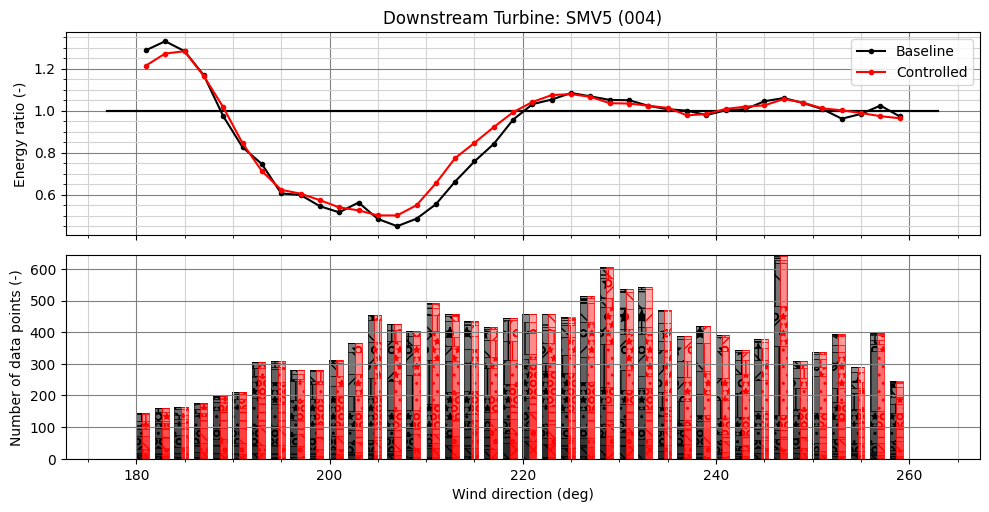

In [12]:
# Check energy ratios on SMV5 (index=4) (downstream turbine)
s.get_energy_ratios(
            test_turbines=[4],
            ws_step=1.0,
            wd_bin_width=2.0,
            wd_step=2.0
        )
ax = s.plot_energy_ratios(show_barplot_legend=False)
ax[0].set_title("Downstream Turbine: SMV5 (004)")

Dataframes differ in wd and ws. Rebalancing.
Calculating energy ratios with N = 1.
Calculating energy ratios with N = 1.


Text(0.5, 1.0, 'Upstream Turbine: SMV6 (005)')

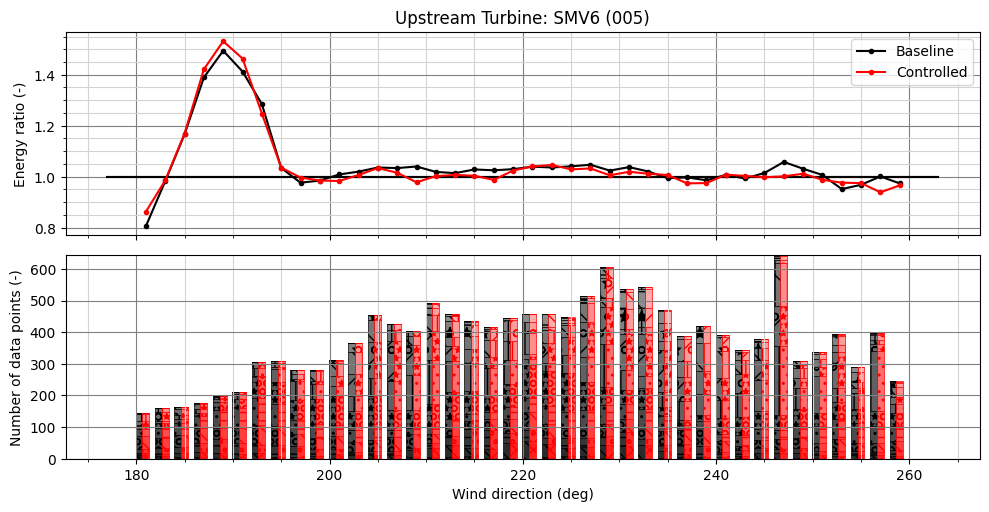

In [13]:
# Check energy ratios on SMV6 (index=5) (upstream turbine)
s.get_energy_ratios(
            test_turbines=[5],
            ws_step=1.0,
            wd_bin_width=2.0,
            wd_step=2.0
        )
ax = s.plot_energy_ratios(show_barplot_legend=False)
ax[0].set_title("Upstream Turbine: SMV6 (005)")

Dataframes differ in wd and ws. Rebalancing.
Calculating energy ratios with N = 1.
Calculating energy ratios with N = 1.


Text(0.5, 1.0, 'Upstream and Downstream Turbines Combined: SMV5+SMV6 (004+005)')

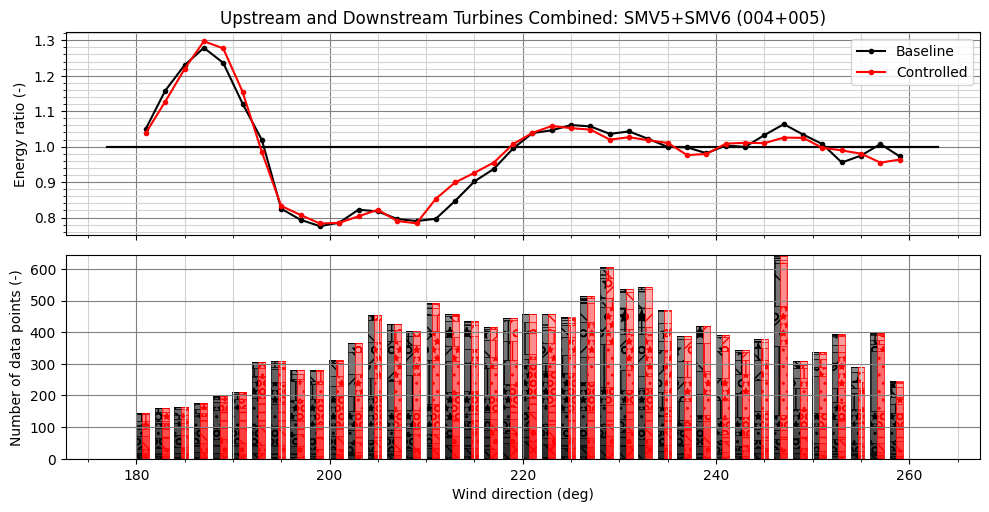

In [14]:
# Check energy ratios on for combination of SMV5 and SMV6
s.get_energy_ratios(
            test_turbines=[5,4],
            ws_step=1.0,
            wd_bin_width=2.0,
            wd_step=2.0
        )
ax = s.plot_energy_ratios(show_barplot_legend=False)
ax[0].set_title("Upstream and Downstream Turbines Combined: SMV5+SMV6 (004+005)")

# Step 4: Use bootstrapping to estimate uncertainty

Now, we'll plot the energy ratio comparisons for the upstream and downstream turbines combined with bootstrapping to quantify uncertainty.

First we'll use normal bootstrapping, in which the timestamps used in the energy ratio calculation are randomly resampled with replacement each bootstrap iteration.

The shaded regions in the plots below indicate the 95% confidence intervals of the mean energy ratio estimates.

Dataframes differ in wd and ws. Rebalancing.
Calculating energy ratios with N = 40.
Calculating energy ratios with N = 40.


array([<Axes: ylabel='Energy ratio (-)'>,
       <Axes: xlabel='Wind direction (deg)', ylabel='Number of data points (-)'>],
      dtype=object)

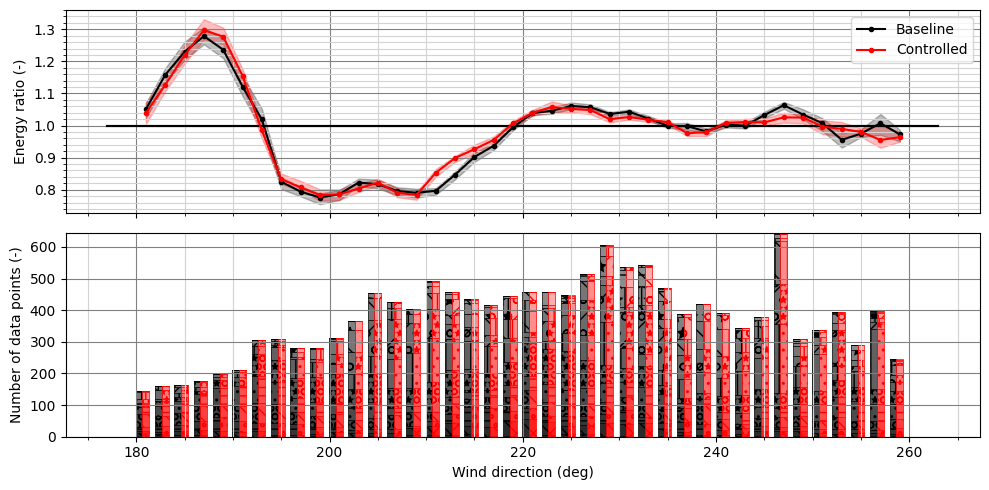

In [15]:
# Check energy ratios on for combination of SMV5 and SMV6
# Using N=40 bootstraps
s.get_energy_ratios(
            test_turbines=[5,4],
            ws_step=1.0,
            wd_bin_width=2.0,
            wd_step=2.0,
            N=40
        )
s.plot_energy_ratios(show_barplot_legend=False)

As expected, the uncertainty is higher for wind directions with fewer data samples.

Next we'll use block bootstrapping, in which the data used in the energy ratio calculation are first grouped into blocks of consecutive timestamps and the individual blocks are randomly resampled with replacement each bootstrap iteration. In this example, we'll divide the data into 10 blocks. Block bootstrapping can provide a more realistic estimate of the true uncertainty than normal bootstrapping.

Dataframes differ in wd and ws. Rebalancing.
Calculating energy ratios with N = 40.
Calculating energy ratios with N = 40.


array([<Axes: ylabel='Energy ratio (-)'>,
       <Axes: xlabel='Wind direction (deg)', ylabel='Number of data points (-)'>],
      dtype=object)

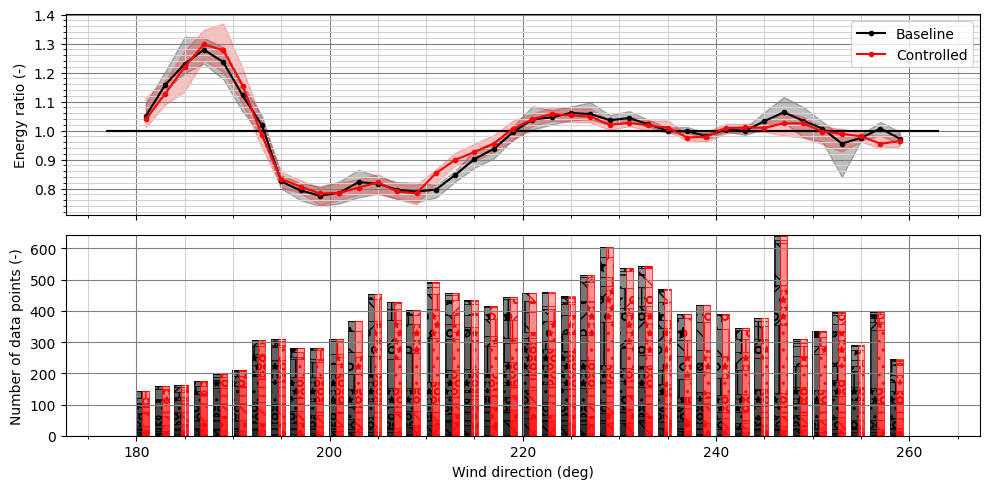

In [16]:
# Check energy ratios on for combination of SMV5 and SMV6
# Using N=40 bootstraps over 10 blocks
s.get_energy_ratios(
            test_turbines=[5,4],
            ws_step=1.0,
            wd_bin_width=2.0,
            wd_step=2.0,
            N=40,
            num_blocks=10
        )
s.plot_energy_ratios(show_barplot_legend=False)

# Step 6: Plot the energy ratio gain with bootstrapping

Next, we will plot the difference between the energy ratios with and without wake steering. These plots will show how much wake steering increases (or decreases) energy production as a function of wind direction. 

The first plot shows the energy ratio gain for the downstream turbine (SMV5) and the second plot shows the energy gain for the two turbines combined.

Dataframes differ in wd and ws. Rebalancing.
Calculating energy ratio gains with N = 40.


Text(0.5, 1.0, 'Downstream Turbine: SMV5 (004)')

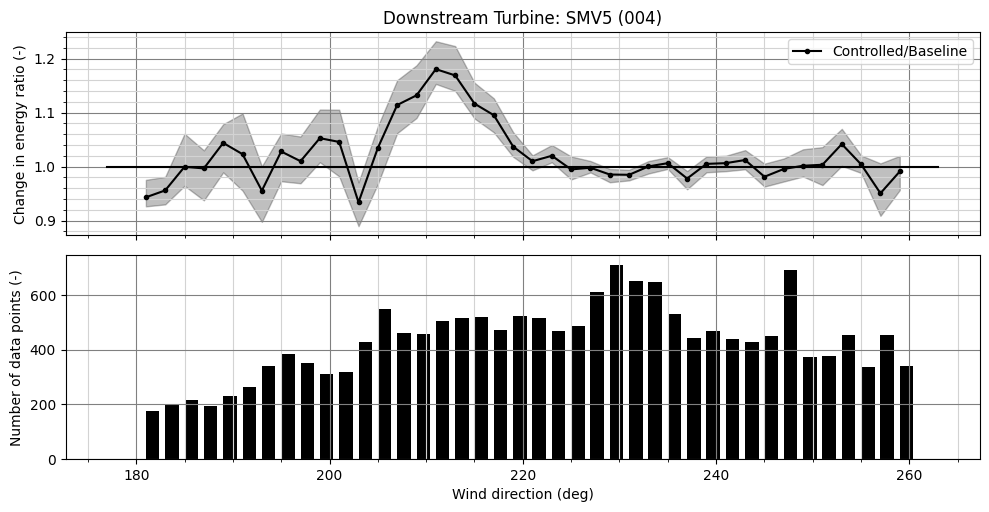

In [17]:
# SMV5 (Downstream)
s.get_energy_ratios_gain(
            test_turbines=[4],
            ws_step=1.0,
            wd_bin_width=2.0,
            wd_step=2.0,
            N=40
        )
ax = s.plot_energy_ratio_gains(show_barplot_legend=False)
ax[0].set_title("Downstream Turbine: SMV5 (004)")

Dataframes differ in wd and ws. Rebalancing.
Calculating energy ratio gains with N = 40.


Text(0.5, 1.0, 'Upstream and Downstream Turbines Combined: SMV5+SMV6 (004+005)')

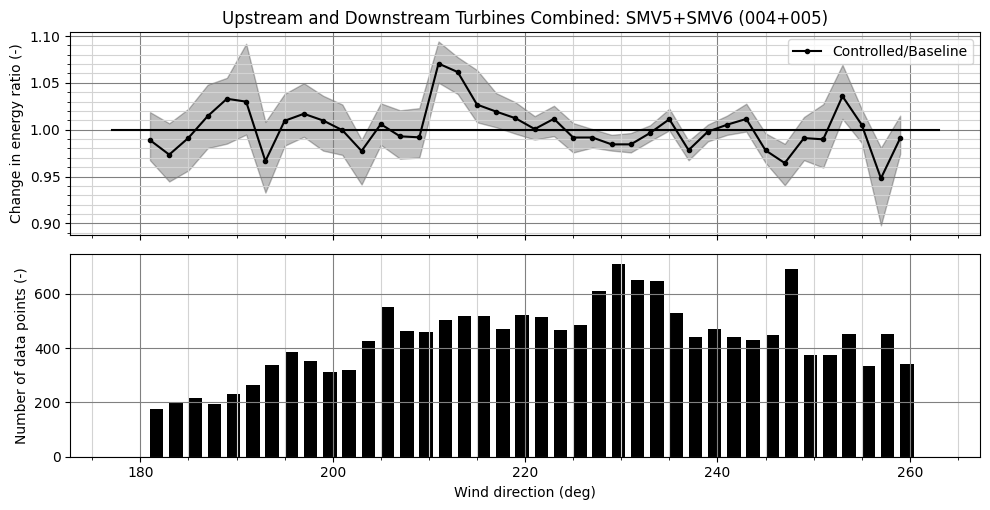

In [18]:
# SMV5 + SMV6 (Combined)
s.get_energy_ratios_gain(
            test_turbines=[4, 5],
            ws_step=1.0,
            wd_bin_width=2.0,
            wd_step=2.0,
            N=40
        )
ax = s.plot_energy_ratio_gains(show_barplot_legend=False)
ax[0].set_title("Upstream and Downstream Turbines Combined: SMV5+SMV6 (004+005)")

The above plots indicate that wake steering increases the energy of the downstream turbine significantly for wind directions between 205 and 220 degrees. When including the upstream turbine, the impact on energy is smaller, but wake steering still yields an increase in energy.

# Step 7: Compare with FLORIS

Now we will compare the observed energy ratios and energy ratio gains for baseline and wake steering control based on SCADA data to the equivalent FLORIS predictions.

In [19]:
# Define a small function to build a dataframe of FLORIS predictions with yaw misalignment 
# for comparison with SCADA

num_turbines = 7
def build_floris_data_frame(fi_in,
                            wind_speeds, 
                            wind_directions, 
                            yaw_angles_in = None,
                            ref_pow_columns=[0, 1, 2, 6]):
    
    fi_ = copy.deepcopy(fi_in)
    
    yaw_angles = np.zeros([len(wind_directions),1,num_turbines])
    if yaw_angles_in is not None:
        yaw_angles[:,0, 5] = yaw_angles_in # Apply angles to SMV6
    
    fi_.reinitialize(wind_speeds=wind_speeds, 
                        wind_directions=wind_directions,
                        time_series=True
                        )

    fi_.calculate_wake(yaw_angles=yaw_angles)

    turbine_powers = fi_.get_turbine_powers().squeeze()/1000.

    df_ = pd.DataFrame(turbine_powers,
                       columns=["pow_{:03d}".format(ii) for ii in range(num_turbines)]
                       )
    
    df_ = df_.assign(
        ws = wind_speeds,
        wd = wind_directions,
        pow_ref = df_[["pow_{:03d}".format(ii) for ii in ref_pow_columns]].mean(axis=1)
    )

    return df_

## Comparison assuming no wind direction uncertainty/variability in FLORIS

Compute FLORIS predictions of power production for the time series of reference wind directions and wind speeds in the SCADA data set, using the Gauss-Curl Hybrid wake model. The yaw misalignment of the steered turbine, SMV6 (005), is set to the measured wind vane angle at each timestamp. Yaw misalignments for all other turbines are set to 0.

In [20]:
fi = load_smarteole_floris('gch',wd_std=0.0)

In [21]:
# Resimulate FLORIS using time-domain sim assuming all yaws are 0 except for SMV5, which follows either target exactly or 
# what is measured via the vane

# Baseline / Perfect yawing
wind_speeds_baseline = df_base.ws.values
wind_directions_baseline = df_base.wd.values
yaw_angles_baseline_target = None
yaw_angles_baseline_measured = df_base.wind_vane_005.values

wind_speeds_con = df_con.ws.values
wind_directions_con = df_con.wd.values
yaw_angles_con_target = df_con.target_yaw_offset_005.values
yaw_angles_con_measured = df_con.wind_vane_005.values

# Compute FLORIS assuming target offsets and no wd std
df_floris_target_offset_baseline = build_floris_data_frame(fi,wind_speeds_baseline,wind_directions_baseline,yaw_angles_baseline_target)
df_floris_target_offset_con = build_floris_data_frame(fi,wind_speeds_con,wind_directions_con,yaw_angles_con_measured)

# Compute using measured offsets
# df_floris_measured_offset_baseline = build_floris_data_frame(fi,wind_speeds_baseline,wind_directions_baseline,yaw_angles_baseline_target)
# df_floris_measured_offset_con = build_floris_data_frame(fi,wind_speeds_con,wind_directions_con,yaw_angles_con_measured)


Now we'll plot a comparison of the energy ratios based on SCADA data and FLORIS predictions for the downstream turbine SMV5 (004).

Dataframes differ in wd and ws. Rebalancing.
Calculating energy ratios with N = 1.
Calculating energy ratios with N = 1.
Calculating energy ratios with N = 1.
Calculating energy ratios with N = 1.


Text(0.5, 1.0, 'Downstream Turbine: SMV5 (004)')

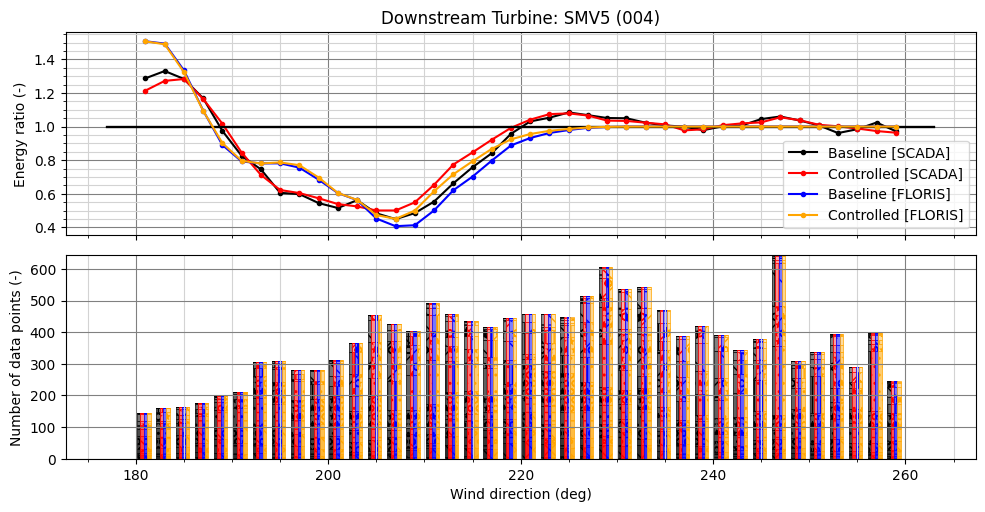

In [22]:
# Construct energy ratio object
s = energy_ratio_suite.energy_ratio_suite()
s.add_df(df_base, name="Baseline [SCADA]", color='k')
s.add_df(df_con, name="Controlled [SCADA]", color='r')
s.add_df(df_floris_target_offset_baseline, name="Baseline [FLORIS]", color='b')
s.add_df(df_floris_target_offset_con, name="Controlled [FLORIS]", color='orange')

s.get_energy_ratios(
            test_turbines=[4],
            ws_step=1.0,
            wd_bin_width=2.0,
            wd_step=2.0
        )
ax = s.plot_energy_ratios(show_barplot_legend=False)
ax[0].set_title("Downstream Turbine: SMV5 (004)")

The FLORIS predictions agree reasonably well with the SCADA-based energy ratios, although FLORIS predicts slightly lower wake losses overall. Note that the SCADA-based energy ratios exceed 1 at the edge of the wake between 220 and 235 degrees, whereas FLORIS predicts energy ratios of 1. The higher SCADA-based energy ratios could indicate a speed up region at the edge of the wake where SMV5 outperforms the reference turbines.  

## Compare the energy ratio gains from SCADA and FLORIS

Lastly, we'll compare the changes in the energy ratios from wake steering based on the SCADA data with the equivalent FLORIS predictions for the downstream turbine adn the two turbines combined.

Dataframes differ in wd and ws. Rebalancing.
Calculating energy ratio gains with N = 40.
Calculating energy ratio gains with N = 40.


Text(0.5, 1.0, 'Downstream Turbine: SMV5 (004)')

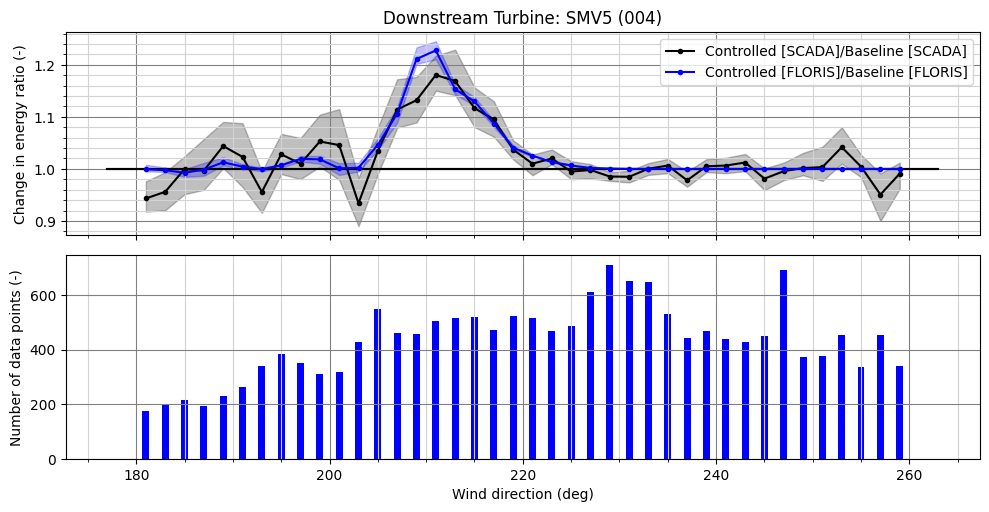

In [23]:
# Downstream only
s.get_energy_ratios_gain(
            test_turbines=[4],
            ws_step=1.0,
            wd_bin_width=2.0,
            wd_step=2.0,
            N=40
        )
ax = s.plot_energy_ratio_gains(show_barplot_legend=False)
ax[0].set_title("Downstream Turbine: SMV5 (004)")

Dataframes differ in wd and ws. Rebalancing.
Calculating energy ratio gains with N = 40.
Calculating energy ratio gains with N = 40.


Text(0.5, 1.0, 'Upstream and Downstream Turbines Combined: SMV5+SMV6 (004+005)')

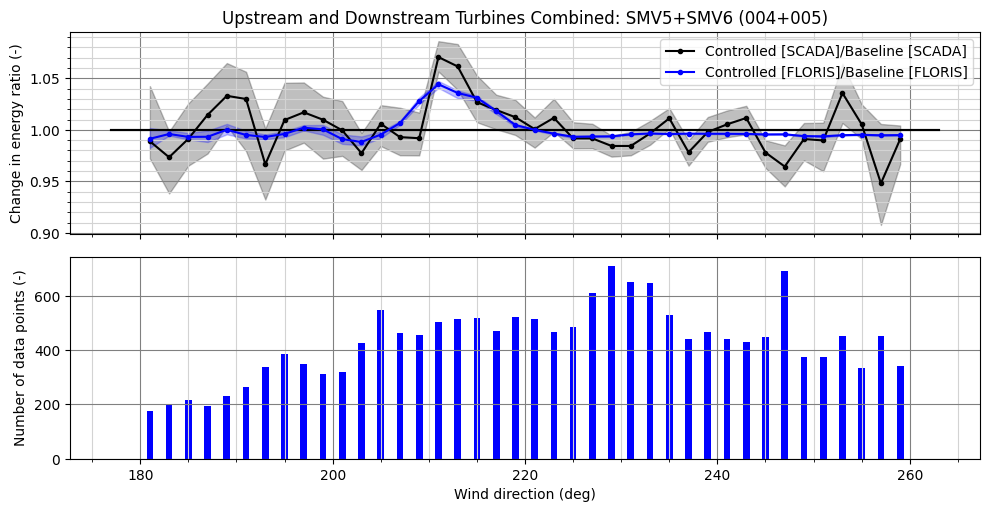

In [24]:
# Combined
s.get_energy_ratios_gain(
            test_turbines=[4, 5],
            ws_step=1.0,
            wd_bin_width=2.0,
            wd_step=2.0,
            N=40
        )
ax = s.plot_energy_ratio_gains(show_barplot_legend=False)
ax[0].set_title("Upstream and Downstream Turbines Combined: SMV5+SMV6 (004+005)")

In general, although the SCADA-based energy ratios are much noisier than the FLORIS predictions, the observed energy gains are relatively close tot he predicted gains.